In [ ]:
# innhenting og beregning av data

import requests
import pandas as pd
from itertools import product
from pandasql import sqldf

# ------------------------------
# 1. Hente data fra SSB
# ------------------------------
API_URL = "https://data.ssb.no/api/v0/no/table/03024/"

def fetch_data(api_url=API_URL):
    """Henter data fra SSB API og returnerer JSON-responsen."""
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    response = requests.post(api_url, json=query)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Feil ved henting av data: {response.status_code}\n{response.text}")


# ------------------------------
# 2. Prosessere og strukturere data
# ------------------------------
def process_data(data):
    """Prosesserer JSON-data og returnerer en formatert Pandas DataFrame."""
    dimension_names = list(data["dimension"].keys())
    values = data["value"]
    
    dimensions = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dimension_names]
    all_combinations = list(product(*dimensions))

    df = pd.DataFrame(all_combinations, columns=dimension_names)
    df["Value"] = values
    
    # Pivot for å få én kolonne per måling
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()

    # Navngi kolonner tydelig
    df_pivot.columns = ["År og ukenr.", 
                        "Fersk laks - Kilospris", 
                        "Fersk laks - Vekt (tonn)", 
                        "Frosset laks - Kilospris", 
                        "Frosset laks - Vekt (tonn)"]

    print("\n Manglende verdier i df_pivot:")
    print(df_pivot.isna().sum())

    return df_pivot


# ------------------------------
# 3. Beregne CO₂-utslipp
# ------------------------------
CO2_FACTORS = {
    "Fersk laks": 1.1,    # kg CO₂ per tonn-km (fly)
    "Frosset laks": 0.01  # kg CO₂ per tonn-km (skip)
}

DISTANCES = {
    "Fersk laks": 2000,
    "Frosset laks": 5000
}

def beregn_co2_utslipp(df):
    """Legger til CO₂-utslipp basert på vekt og transporttype."""
    df_melted = pd.melt(
        df, 
        id_vars=["År og ukenr."], 
        value_vars=["Fersk laks - Vekt (tonn)", "Frosset laks - Vekt (tonn)"],
        var_name="Type", 
        value_name="Vekt (tonn)"
    )
    df_melted.dropna(subset=["Vekt (tonn)"], inplace=True)

    df_melted["Transporttype"] = df_melted["Type"].apply(lambda x: "Fersk laks" if "Fersk" in x else "Frosset laks")

    df_melted["CO2-utslipp (kg)"] = [
        vekt * CO2_FACTORS[typ] * DISTANCES[typ]
        for vekt, typ in zip(df_melted["Vekt (tonn)"], df_melted["Transporttype"])
    ]
    
    return df_melted


# ------------------------------
# 4. Bruk av Pandas SQL for analyse
# ------------------------------
def total_utslipp_per_uke(df):
    """Oppsummerer CO₂-utslipp per uke med SQL."""
    query = """
        SELECT 
            `År og ukenr.`, 
            Transporttype, 
            SUM(`CO2-utslipp (kg)`) AS `Total CO2-utslipp (kg)`
        FROM df
        GROUP BY `År og ukenr.`, Transporttype
        ORDER BY `År og ukenr.`
    """
    return sqldf(query)


# ------------------------------
# 5. Kjør alt sammen
# ------------------------------
def main():
    try:
        data = fetch_data()
        df_pivot = process_data(data)

        df_clean = df_pivot.dropna(subset=["Fersk laks - Vekt (tonn)", "Frosset laks - Vekt (tonn)"], how='all')

        df_with_co2 = beregn_co2_utslipp(df_clean)
        df_summary = total_utslipp_per_uke(df_with_co2)

        # PIVOT: Gjør én kolonne for hver laks-type
        df_pivoted = df_summary.pivot(index="År og ukenr.", columns="Transporttype", values="Total CO2-utslipp (kg)").reset_index()
        df_pivoted.columns.name = None  # Fjern kolonne-navngruppe
        df_pivoted.rename(columns={
            "Fersk laks": "Fersk laks - CO2 (kg)",
            "Frosset laks": "Frosset laks - CO2 (kg)"
        }, inplace=True)

        print(df_pivoted.to_string(index=False))
        print("\nTabellen viser CO₂-utslipp per uke, fordelt etter laksetype.")

        return df_with_co2  

    except Exception as e:
        print("Feil:", e)


if __name__ == "__main__":
    main()



 Manglende verdier i df_pivot:
År og ukenr.                  0
Fersk laks - Kilospris        0
Fersk laks - Vekt (tonn)      0
Frosset laks - Kilospris      0
Frosset laks - Vekt (tonn)    0
dtype: int64
År og ukenr.  Fersk laks - CO2 (kg)  Frosset laks - CO2 (kg)
     2000U01              8201600.0                  19150.0
     2000U02              8918800.0                  10800.0
     2000U03              8894600.0                  31650.0
     2000U04              8206000.0                  19650.0
     2000U05              8428200.0                  22650.0
     2000U06              9713000.0                  13250.0
     2000U07             10157400.0                  17200.0
     2000U08              9818600.0                  27100.0
     2000U09              8855000.0                  24500.0
     2000U10              9402800.0                  36900.0
     2000U11             10553400.0                  41000.0
     2000U12             11008800.0                  37350.0
  

In [1]:
# videre analyser og visualiseringer

import matplotlib.pyplot as plt

def vis_fersk_uke1_siste_10år(df_with_co2):
    # Oppsummer CO2 per uke og pivotér
    df_summary = total_utslipp_per_uke(df_with_co2)
    df_pivoted = df_summary.pivot(index="År og ukenr.", columns="Transporttype", values="Total CO2-utslipp (kg)").reset_index()
    df_pivoted.columns.name = None

    # Filtrer: Kun uke 1 og siste 10 år
    df_uke1 = df_pivoted[df_pivoted["År og ukenr."].str.endswith("U01")].copy()

    # Konverter år fra "2020U01" til int
    df_uke1["År"] = df_uke1["År og ukenr."].str[:4].astype(int)

    # Sorter og ta siste 10 år
    df_uke1 = df_uke1.sort_values("År").tail(20)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df_uke1["År"], df_uke1["Fersk laks"], color="royalblue", marker="o", linewidth=2)

    plt.title("CO₂-utslipp for fersk laks – uke 1, siste 10 år", fontsize=16)
    plt.xlabel("År", fontsize=12)
    plt.ylabel("CO₂-utslipp (kg)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.xticks(df_uke1["År"])
    plt.tight_layout()
    plt.show()

In [2]:
import matplotlib.pyplot as plt

def vis_frosset_uke1_siste_10år(df_with_co2):
    # Oppsummer CO2 per uke og pivotér
    df_summary = total_utslipp_per_uke(df_with_co2)
    df_pivoted = df_summary.pivot(index="År og ukenr.", columns="Transporttype", values="Total CO2-utslipp (kg)").reset_index()
    df_pivoted.columns.name = None

    # Filtrer til kun uke 1 og lag kopi
    df_uke1 = df_pivoted[df_pivoted["År og ukenr."].str.endswith("U01")].copy()
    df_uke1["År"] = df_uke1["År og ukenr."].str[:4].astype(int)

    # Sorter og ta de siste 10 årene
    df_uke1 = df_uke1.sort_values("År").tail(20)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df_uke1["År"], df_uke1["Frosset laks"], color="darkorange", marker="s", linewidth=2)

    plt.title("CO₂-utslipp for frosset laks – uke 1, siste 10 år", fontsize=16)
    plt.xlabel("År", fontsize=12)
    plt.ylabel("CO₂-utslipp (kg)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.xticks(df_uke1["År"])
    plt.tight_layout()
    plt.show()

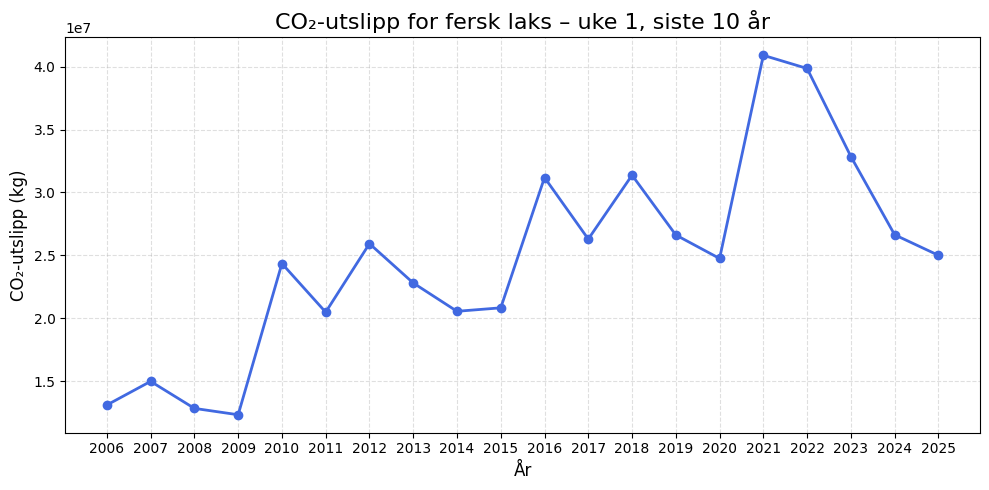

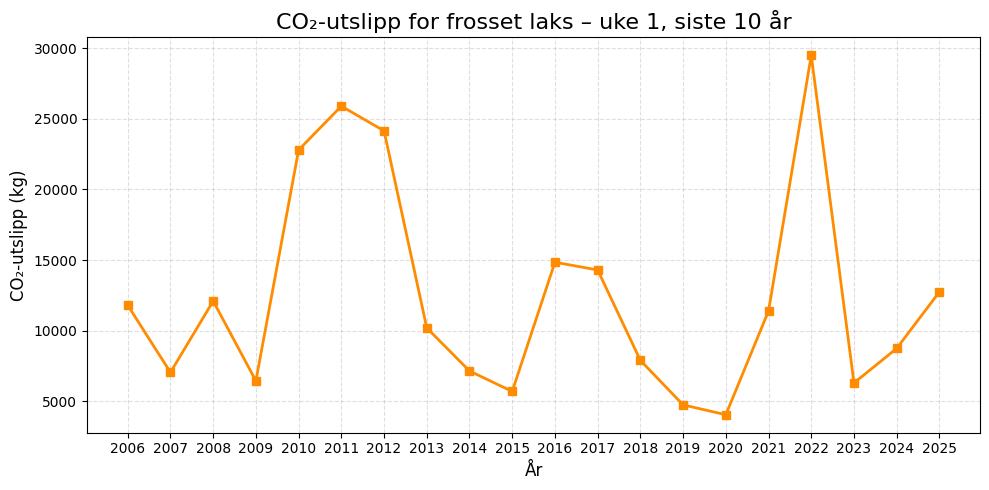

In [86]:
vis_fersk_uke1_siste_10år(df_with_co2)    
vis_frosset_uke1_siste_10år(df_with_co2)

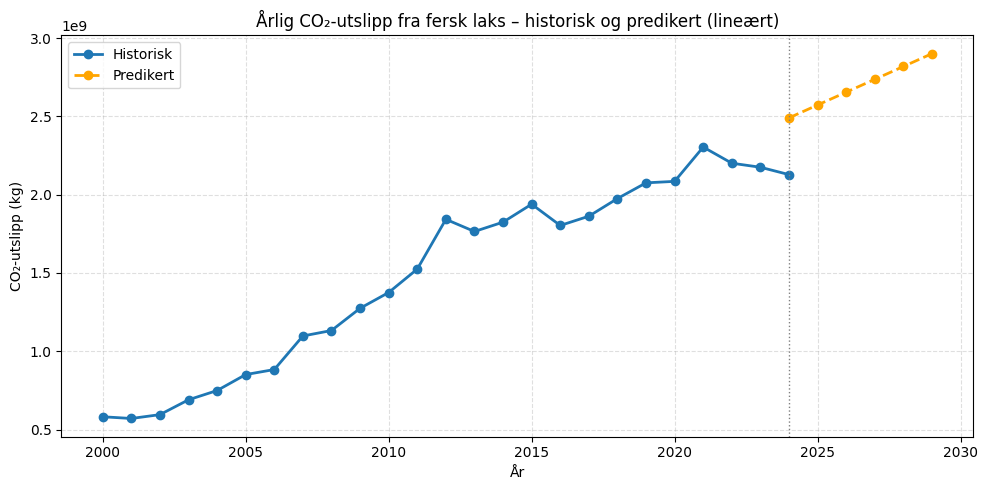

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from itertools import product
from pandasql import sqldf

# --------------------------------------
# 1. Hente og prosessere data fra SSB
# --------------------------------------
API_URL = "https://data.ssb.no/api/v0/no/table/03024/"

def fetch_data(api_url=API_URL):
    query = {"query": [], "response": {"format": "json-stat2"}}
    response = requests.post(api_url, json=query)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Feil ved henting av data: {response.status_code}")

def process_data(data):
    dimension_names = list(data["dimension"].keys())
    values = data["value"]
    dimensions = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dimension_names]
    all_combinations = list(product(*dimensions))
    df = pd.DataFrame(all_combinations, columns=dimension_names)
    df["Value"] = values
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"],
                               values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["År og ukenr.", 
                        "Fersk laks - Kilospris", 
                        "Fersk laks - Vekt (tonn)", 
                        "Frosset laks - Kilospris", 
                        "Frosset laks - Vekt (tonn)"]
    return df_pivot

# --------------------------------------
# 2. Beregne CO₂-utslipp
# --------------------------------------
CO2_FACTORS = {"Fersk laks": 1.1, "Frosset laks": 0.01}
DISTANCES = {"Fersk laks": 2000, "Frosset laks": 5000}

def beregn_co2_utslipp(df):
    df_melted = pd.melt(df, id_vars=["År og ukenr."], 
                        value_vars=["Fersk laks - Vekt (tonn)", "Frosset laks - Vekt (tonn)"],
                        var_name="Type", value_name="Vekt (tonn)")
    df_melted.dropna(subset=["Vekt (tonn)"], inplace=True)
    df_melted["Transporttype"] = df_melted["Type"].apply(lambda x: "Fersk laks" if "Fersk" in x else "Frosset laks")
    df_melted["CO2-utslipp (kg)"] = [
        vekt * CO2_FACTORS[typ] * DISTANCES[typ]
        for vekt, typ in zip(df_melted["Vekt (tonn)"], df_melted["Transporttype"])
    ]
    return df_melted

def total_utslipp_per_uke(df):
    query = """
        SELECT 
            `År og ukenr.`, 
            Transporttype, 
            SUM(`CO2-utslipp (kg)`) AS `Total CO2-utslipp (kg)`
        FROM df
        GROUP BY `År og ukenr.`, Transporttype
        ORDER BY `År og ukenr.`
    """
    return sqldf(query)

def main():
    data = fetch_data()
    df_pivot = process_data(data)
    df_clean = df_pivot.dropna(subset=["Fersk laks - Vekt (tonn)", "Frosset laks - Vekt (tonn)"], how='all')
    df_with_co2 = beregn_co2_utslipp(df_clean)
    return df_with_co2

# --------------------------------------
# 3. Prediksjon med NumPy (kun fersk laks)
# --------------------------------------
def predikér_fersk_laks_np(df_with_co2):
    df_fersk = df_with_co2[df_with_co2["Transporttype"] == "Fersk laks"].copy()
    df_fersk["År"] = df_fersk["År og ukenr."].str[:4].astype(int)

    # Summer CO₂ per år
    df_yearly = df_fersk.groupby("År")["CO2-utslipp (kg)"].sum().reset_index()

    # Bruk kun år t.o.m. 2023
    treningsdata = df_yearly[df_yearly["År"] <= 2023]
    x = treningsdata["År"].values
    y = treningsdata["CO2-utslipp (kg)"].values

    # Lineær regresjon
    coeffs = np.polyfit(x, y, deg=1)
    trend = np.poly1d(coeffs)

    # Prediker fremtidige år
    future_years = np.arange(2024, 2030)
    predicted = trend(future_years)

    # Plot
    plt.figure(figsize=(10, 5))
    historisk = df_yearly[df_yearly["År"] <= 2024]
    plt.plot(historisk["År"], historisk["CO2-utslipp (kg)"], marker='o', linewidth=2, label="Historisk")
    plt.plot(future_years, predicted, marker='o', linestyle='--', linewidth=2, color='orange', label="Predikert")
    plt.axvline(x=2024, color="gray", linestyle=":", linewidth=1)
    plt.title("Årlig CO₂-utslipp fra fersk laks – historisk og predikert (lineært)")
    plt.xlabel("År")
    plt.ylabel("CO₂-utslipp (kg)")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --------------------------------------
# 4. Kjør alt
# --------------------------------------
df_with_co2 = main()
predikér_fersk_laks_np(df_with_co2)


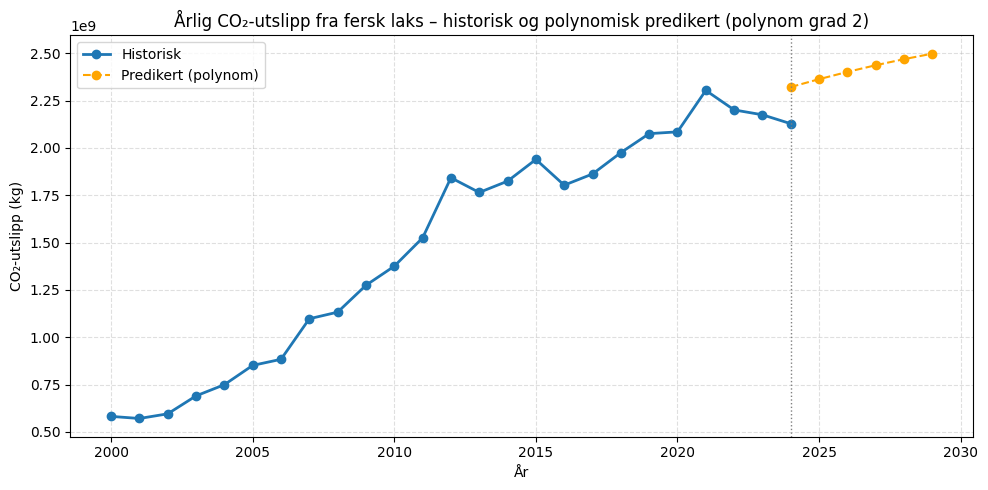

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from itertools import product
from pandasql import sqldf

# --------------------------------------
# 1. Hente og prosessere data fra SSB
# --------------------------------------
API_URL = "https://data.ssb.no/api/v0/no/table/03024/"

def fetch_data(api_url=API_URL):
    query = {"query": [], "response": {"format": "json-stat2"}}
    response = requests.post(api_url, json=query)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Feil ved henting av data: {response.status_code}")

def process_data(data):
    dimension_names = list(data["dimension"].keys())
    values = data["value"]
    dimensions = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dimension_names]
    all_combinations = list(product(*dimensions))
    df = pd.DataFrame(all_combinations, columns=dimension_names)
    df["Value"] = values
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"],
                               values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["År og ukenr.", 
                        "Fersk laks - Kilospris", 
                        "Fersk laks - Vekt (tonn)", 
                        "Frosset laks - Kilospris", 
                        "Frosset laks - Vekt (tonn)"]
    return df_pivot

# --------------------------------------
# 2. Beregne CO₂-utslipp
# --------------------------------------
CO2_FACTORS = {"Fersk laks": 1.1, "Frosset laks": 0.01}
DISTANCES = {"Fersk laks": 2000, "Frosset laks": 5000}

def beregn_co2_utslipp(df):
    df_melted = pd.melt(df, id_vars=["År og ukenr."], 
                        value_vars=["Fersk laks - Vekt (tonn)", "Frosset laks - Vekt (tonn)"],
                        var_name="Type", value_name="Vekt (tonn)")
    df_melted.dropna(subset=["Vekt (tonn)"], inplace=True)
    df_melted["Transporttype"] = df_melted["Type"].apply(lambda x: "Fersk laks" if "Fersk" in x else "Frosset laks")
    df_melted["CO2-utslipp (kg)"] = [
        vekt * CO2_FACTORS[typ] * DISTANCES[typ]
        for vekt, typ in zip(df_melted["Vekt (tonn)"], df_melted["Transporttype"])
    ]
    return df_melted

def total_utslipp_per_uke(df):
    query = """
        SELECT 
            `År og ukenr.`, 
            Transporttype, 
            SUM(`CO2-utslipp (kg)`) AS `Total CO2-utslipp (kg)`
        FROM df
        GROUP BY `År og ukenr.`, Transporttype
        ORDER BY `År og ukenr.`
    """
    return sqldf(query)

def main():
    data = fetch_data()
    df_pivot = process_data(data)
    df_clean = df_pivot.dropna(subset=["Fersk laks - Vekt (tonn)", "Frosset laks - Vekt (tonn)"], how='all')
    df_with_co2 = beregn_co2_utslipp(df_clean)
    return df_with_co2

def predikér_fersk_laks_polynom(df_with_co2):
    df_fersk = df_with_co2[df_with_co2["Transporttype"] == "Fersk laks"].copy()
    df_fersk["År"] = df_fersk["År og ukenr."].str[:4].astype(int)

    # Summer CO₂ per år
    df_yearly = df_fersk.groupby("År")["CO2-utslipp (kg)"].sum().reset_index()

    # Bruk bare ferdige år (t.o.m. 2023)
    treningsdata = df_yearly[df_yearly["År"] <= 2023]
    x = treningsdata["År"].values
    y = treningsdata["CO2-utslipp (kg)"].values

    # === Polynomisk regresjon (grad 2) ===
    coeffs = np.polyfit(x, y, deg=2)
    trend = np.poly1d(coeffs)

    # Fremtidige år å predikere
    future_years = np.arange(2024, 2030)
    predicted = trend(future_years)

    # === Plot ===
    plt.figure(figsize=(10, 5))

    # Historisk (vis gjerne 2024 også, men ikke som modellgrunnlag)
    historisk = df_yearly[df_yearly["År"] <= 2024]
    plt.plot(historisk["År"], historisk["CO2-utslipp (kg)"], marker='o', linewidth=2, label="Historisk")

    # Prediksjon
    plt.plot(future_years, predicted, marker='o', linestyle='--', color='orange', label="Predikert (polynom)")

    # Skillelinje
    plt.axvline(x=2024, color="gray", linestyle=":", linewidth=1)

    plt.title("Årlig CO₂-utslipp fra fersk laks – historisk og polynomisk predikert (polynom grad 2)")
    plt.xlabel("År")
    plt.ylabel("CO₂-utslipp (kg)")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

predikér_fersk_laks_polynom(df_with_co2)

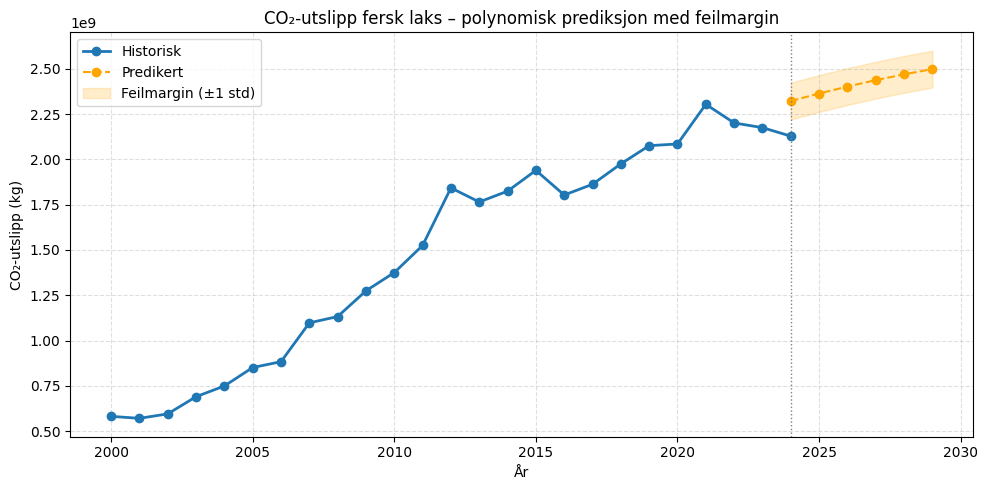

In [106]:
def predikér_fersk_laks_polynom_med_feilmargin(df_with_co2):
    df_fersk = df_with_co2[df_with_co2["Transporttype"] == "Fersk laks"].copy()
    df_fersk["År"] = df_fersk["År og ukenr."].str[:4].astype(int)

    # Summer CO₂ per år
    df_yearly = df_fersk.groupby("År")["CO2-utslipp (kg)"].sum().reset_index()

    # Bruk bare fullførte år (t.o.m. 2023)
    treningsdata = df_yearly[df_yearly["År"] <= 2023]
    x = treningsdata["År"].values
    y = treningsdata["CO2-utslipp (kg)"].values

    # Polynomisk regresjon (grad 2)
    coeffs = np.polyfit(x, y, deg=2)
    trend = np.poly1d(coeffs)

    # Forutsig fremtidige år
    future_years = np.arange(2024, 2030)
    predicted = trend(future_years)

    # === Estimer feil (residual standard deviation) ===
    y_pred_train = trend(x)
    residuals = y - y_pred_train
    std_dev = np.std(residuals)

    # Lag øvre og nedre grense
    upper = predicted + std_dev
    lower = predicted - std_dev

    # === Plot ===
    plt.figure(figsize=(10, 5))

    # Historiske data (inkl. 2024 hvis du ønsker)
    historisk = df_yearly[df_yearly["År"] <= 2024]
    plt.plot(historisk["År"], historisk["CO2-utslipp (kg)"], marker='o', linewidth=2, label="Historisk")

    # Prediksjon med usikkerhetsbånd
    plt.plot(future_years, predicted, linestyle='--', marker='o', color='orange', label="Predikert")
    plt.fill_between(future_years, lower, upper, color='orange', alpha=0.2, label="Feilmargin (±1 std)")

    # Vertikal skille
    plt.axvline(x=2024, color="gray", linestyle=":", linewidth=1)

    plt.title("CO₂-utslipp fersk laks – polynomisk prediksjon med feilmargin")
    plt.xlabel("År")
    plt.ylabel("CO₂-utslipp (kg)")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

predikér_fersk_laks_polynom_med_feilmargin(df_with_co2)